In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
data = np.genfromtxt("measurements/test_with_simulation_25A_Working_new_mat.csv", delimiter=',')

time = data[:,0]/1000
c_raw = data[:,5]
c_filt_ard = data[:,2]
c_pred = data[:,6]

# Clip data 
c_filt_ard = np.clip(c_filt_ard, -10, 50)
c_raw = np.clip(c_raw, -10, 50)
c_pred = np.clip(c_pred, -10, 50)

In [3]:
filter_taps = np.array([-0.01259277478717816, -0.02704833486706803, -0.031157016036431583, -0.003351666747179282, 0.06651710329324828, 0.1635643048779222, 0.249729473226146, 0.2842779082622769, 0.249729473226146, 0.1635643048779222, 0.06651710329324828, -0.003351666747179282, -0.031157016036431583, -0.02704833486706803, -0.01259277478717816])
SAMPLEFILTER_TAP_NUM = filter_taps.shape[0]

class Filter:
    def __init__(self, taps):
        self.taps = taps
        self.buffer = np.zeros(SAMPLEFILTER_TAP_NUM)
        self.index = 0

    def updateValue(self, input):
        self.buffer[self.index] = input
        self.index = (self.index + 1) % SAMPLEFILTER_TAP_NUM
        return np.dot(self.taps, self.buffer)


filter = Filter(filter_taps)
c_filtered = np.zeros(c_raw.shape[0])
for i in range(c_raw.shape[0]):
    c_filtered[i] = filter.updateValue(c_raw[i])

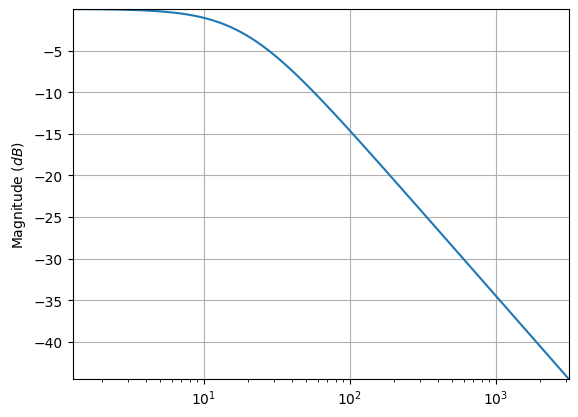

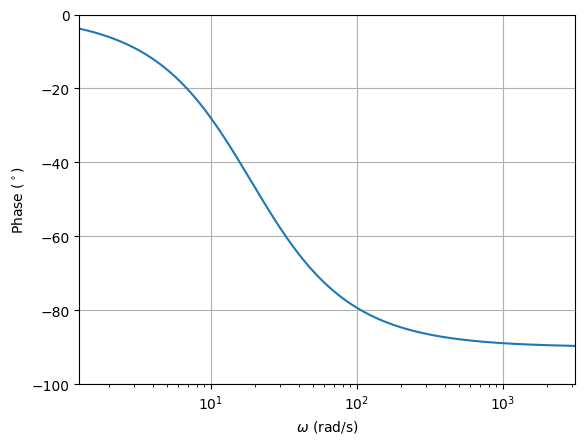

In [5]:
%matplotlib inline
# Generate the bode plot
signalFreq = [2, 50]
w = np.logspace( np.log10(min(signalFreq)*2*np.pi/10), np.log10(max(signalFreq)*2*np.pi*10), 500 )
w, mag, phase = signal.bode(lowPass,w)

# Magnitude plot
plt.figure()
plt.semilogx(w, mag)
plt.ylabel("Magnitude ($dB$)")
plt.xlim([min(w),max(w)])
plt.ylim([min(mag),max(mag)])
plt.grid()

# Phase plot
plt.figure()
plt.semilogx(w, phase)  # Bode phase plot
plt.ylabel("Phase ($^\circ$)")
plt.xlabel("$\omega$ (rad/s)")
plt.xlim([min(w),max(w)])
plt.ylim([-100, 0])
plt.grid()
plt.show()

In [31]:
# Moving Average filter 10 samples with hamming window
window = signal.hamming(10)
window /= np.sum(window)
c_filtered_ma = np.convolve(c_raw, window, mode='same')


In [41]:
hamming_coefs_2 = [0.08, 0.15, 0.22, 0.29, 0.36, 0.43, 0.5, 0.43, 0.36, 0.29]
hamming_coefs = np.zeros(10)
for i in range(10):
    hamming_coefs[i] = 0.54 - 0.46*np.cos(2*np.pi*i/9)
print(hamming_coefs)
plt.plot(hamming_coefs)

def movingAvHamming(input_value):
    buffer = np.zeros(10)
    c_ind = 0
    filtered_value = 0

    buffer[c_ind] = input_value
    for i in range(10):
        # index = (c_ind + i) % 10
        # filtered_value += buffer[index] * hamming_coefs[index]
        filtered_value += buffer[i] * hamming_coefs[i]
    
    c_ind = (c_ind + 1) % 10
    return filtered_value

c_filtered_ma_hamming = np.zeros(c_raw.shape[0])
for i in range(c_raw.shape[0]):
    c_filtered_ma_hamming[i] = movingAvHamming(c_raw[i])


[0.08       0.18761956 0.46012184 0.77       0.97225861 0.97225861
 0.77       0.46012184 0.18761956 0.08      ]


In [18]:
class LPFilter:
    def __init__(self, num, den):
        self.num = num
        self.den = den
        self.buffer_x = np.zeros(len(num)) # x_n, x_n-1, x_n-2, ...
        self.buffer_y = np.zeros(len(den)) # y_n, y_n-1, y_n-2, ...
        self.index = 0
    def updateValue(self, input):
        self.buffer_x[self.index] = input
        self.buffer_y[self.index] = 1 / self.den[0] * (np.dot(self.num, self.buffer_x) - np.dot(self.den[1:], self.buffer_y[1:]))
        self.index = (self.index + 1) % len(self.num)
        return self.buffer_y[self.index]


fs = 100
f_cut = 5
a = 2*np.pi*f_cut
Ts = 1/fs
filt_num = np.array([a*Ts, a*Ts])
filt_den = np.array([a*Ts+2, a*Ts - 2])

lp_filter = LPFilter(filt_num, filt_den)

c_filtered_lp = np.zeros(c_raw.shape[0])
for i in range(c_raw.shape[0]):
    c_filtered_lp[i] = lp_filter.updateValue(c_raw[i])

In [8]:
%matplotlib qt
plt.figure(figsize=(12, 8))
plt.plot(time, c_raw, label='c_raw')
plt.plot(time, c_filt_ard, label='c_filt_ard')
# plt.plot(time, c_pred, label='c_pred')
plt.plot(time, c_filtered_lp, 'r-', label='c_filtered')
plt.legend()
plt.grid()
plt.show()

In [20]:
from myFunctions import *
%matplotlib qt

fft_raw, ff_raw = fftTransform(c_raw, 100)
fft_filt_ard, ff_filt_ard = fftTransform(c_filt_ard, 100)
fft_filtered_lp, ff_filtered_lp = fftTransform(c_filtered_lp, 100)

# plot time series
plt.figure(0, figsize=(12, 8))
plotData(0, time, c_raw, label=f"Time Series Raw", timeFlag=True, multiSelectFlag=False, c='k')
plotData(0, time, c_filt_ard, label=f"Time Series Filtered", timeFlag=True, multiSelectFlag=False, c='r')
plotData(0, time, c_filtered_lp, label=f"Time Series Filtered LP", timeFlag=True, multiSelectFlag=False, c='b')

plt.figure(1, figsize=(12, 8))
plotData(1, ff_raw, fft_raw, label=f"FFT Raw", c='k', multiSelectFlag=False)
plotData(1, ff_filt_ard, fft_filt_ard, label=f"FFT Filtered", c='r', multiSelectFlag=False)
plotData(1, ff_filtered_lp, fft_filtered_lp, label=f"FFT Filtered LP", c='b', multiSelectFlag=False)
# plt.xlim([0, 2])
plt.show()